In [1]:
import os
import time
import shutil
import math

import pandas as pd
import numpy as np

import imageio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from scipy import ndimage
import scipy.misc

from sklearn.metrics import confusion_matrix

import seaborn as sns

import itertools

import matplotlib.pyplot as plt

import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator , array_to_img, img_to_array, load_img
from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.convolutional import *
%matplotlib inline

Constants

In [2]:
SELF_PATH = os.getcwd()
PATH_TO_FILE_STREAM = 'G:\\Shared drives\\P-Sick'
PATH_TO_IMAGES = os.path.join(PATH_TO_FILE_STREAM, 'small\\Florence\\20180917a_jpgs\\jpgs')
PATH_TO_TAG_CSV = 'G:\\Shared drives\\P-Sick\\tag_csv\\tagging_data.csv'

PERCENT_TEST = 0.1
PERCENT_TRAINING = (1-PERCENT_TEST)
PERCENT_VALIDATION = 0.1
PERCENT_VALIDATION = PERCENT_VALIDATION/PERCENT_TRAINING

RESIZE_HEIGHT,RESIZE_WIDTH = 224,224

TRAINING_IMAGE_FOLDER = "..\\_training_images"
TESTING_IMAGE_FOLDER = "..\\_testing_images"
VALIDATION_IMAGE_FOLDER = "..\\_validation_images"

NUM_TRAINING_BATCHES = 20
NUM_TESTING_BATCHES = 20
NUM_VALIDATION_BATCHES = 10

IMPACT_CLASSES = ['0','1','2','3','4']
IMPACT_CLASSES_INT = [0,1,2,3,4]

These are a list of the ids for impact
```
NoneId:0  
SwashId:1  
CollisionId:2  
OverwashId:3  
InundationId:4
```

# Getting the image data

1. We need to load the data from the csv
2. Split the images up into training and test set, and then place them in seperate folders.

First lets load the csv that has all the completely tagged image tags.

In [3]:
df_image_tags = pd.read_csv(PATH_TO_TAG_CSV)
df_impact_images = df_image_tags[['image_id','impact']]

# Creating the training,testing and validation sets

In [4]:
df_training_images, df_testing_images = train_test_split(df_impact_images, test_size=PERCENT_TEST ) #
df_training_images, df_validation_images = train_test_split(df_training_images, test_size=PERCENT_VALIDATION) #, random_state=1337

NUM_TRAINING_IMAGES = len(df_training_images)
NUM_TESTING_IMAGES = len(df_testing_images)
NUM_VALIDATION_IMAGES = len(df_validation_images)

SIZE_TRAINING_BATCH = NUM_TRAINING_IMAGES//NUM_TRAINING_BATCHES
SIZE_TESTING_BATCH = NUM_TESTING_IMAGES//NUM_TESTING_BATCHES
SIZE_VALIDATION_BATCH = NUM_VALIDATION_IMAGES//NUM_VALIDATION_BATCHES

print('Number of images',NUM_TRAINING_IMAGES,NUM_TESTING_IMAGES,NUM_VALIDATION_IMAGES)

print('Batch sizes',SIZE_TRAINING_BATCH,SIZE_TESTING_BATCH,SIZE_VALIDATION_BATCH)

Number of images 198 25 25
Batch sizes 9 1 2


# Get the images into the folders

In [5]:
gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

Before we copy the images, remove all files within these folders

In [6]:
def remove_folders(folders):
    for folder in folders:
        try:
            shutil.rmtree(folder)
        except:
            pass

In [7]:
remove_folders([TRAINING_IMAGE_FOLDER,TESTING_IMAGE_FOLDER,VALIDATION_IMAGE_FOLDER])

Create the training, test, and validation folders, and in each have a folder where the folders name is the impact type(0 to 4)

In [8]:
def make_folders(folders):
    for folder in folders:
        try:
            os.mkdir(folder)
        except:
            pass
        
        try:
            for i in IMPACT_CLASSES:#IMPACT_CLASSES:
                os.mkdir(os.path.join(folder, f'{i}'))
        except:
            pass

In [9]:
make_folders([TRAINING_IMAGE_FOLDER,TESTING_IMAGE_FOLDER,VALIDATION_IMAGE_FOLDER])

Copy our training, test, and vaildation images into their respective folders, while keeping metadata with copy2

In [10]:
def copy_images(dict_of_data_sets, augment= False):
    for sets in dict_of_data_sets:
        for index, row in sets['df'].iterrows():
            #if(not str(row['impact']) == '0'):   
            impact_path =  os.path.join(sets['folder_path'],str(row['impact']))
            full_new_path =  os.path.join(impact_path,row['image_id'])

            shutil.copy2(os.path.join(PATH_TO_IMAGES,row['image_id']),  full_new_path)
            
            if augment:
                img = load_img(full_new_path) 

                x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
                x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

                num_augmented_img = 0
                max_augmented_images = 3
                for batch in gen.flow(x, batch_size=1,
                                        save_to_dir=impact_path, save_prefix='augmented', save_format='jpeg'):
                    num_augmented_img += 1
                    if num_augmented_img > max_augmented_images:
                        break  # otherwise the generator would loop indefinitely
    
    print('done copying')

In [11]:
copy_images([
    {
        'folder_path':TRAINING_IMAGE_FOLDER,
        'df':df_training_images
    },
    {
        'folder_path':TESTING_IMAGE_FOLDER,
        'df':df_testing_images
    },
     {
        'folder_path':VALIDATION_IMAGE_FOLDER,
        'df':df_validation_images
    }
])

done copying


# Preprocessing the images

1. create NP arrays for Keras by pointing to where the images are for each set, since the images in each set are in folders labeled 0-4 Keras will be able to apply a class to them

I also tried to find out how to determine a good batch size, and I found [this](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network) which while not the most scholarly of places, is good enough for me 

In [12]:
training_batch = ImageDataGenerator().flow_from_directory(TRAINING_IMAGE_FOLDER, target_size = (RESIZE_HEIGHT,RESIZE_WIDTH), classes = IMPACT_CLASSES, batch_size = SIZE_TRAINING_BATCH)
testing_batch = ImageDataGenerator().flow_from_directory(TESTING_IMAGE_FOLDER, target_size = (RESIZE_HEIGHT,RESIZE_WIDTH), classes = IMPACT_CLASSES, batch_size = SIZE_TESTING_BATCH)
validation_batch = ImageDataGenerator().flow_from_directory(VALIDATION_IMAGE_FOLDER, target_size = (RESIZE_HEIGHT,RESIZE_WIDTH), classes = IMPACT_CLASSES, batch_size = SIZE_VALIDATION_BATCH)

Found 198 images belonging to 5 classes.
Found 25 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


This function `plots` is used to just show some of the images in a batch and their class

In [13]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))

    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

Show some of the image 

C:\Users\skool\.virtualenvs\Poststorm_Imagery-AfucPPEW\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


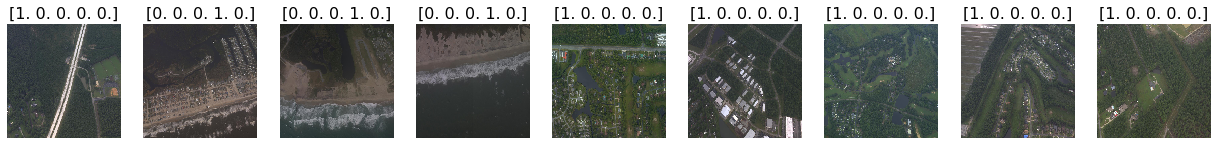

In [14]:
imgs, labels = next(training_batch)
plots(imgs,titles=labels,figsize=(24,6),rows = 1)

# Create Model

In [15]:
model_vgg16 = tensorflow.keras.applications.vgg16.VGG16()
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
model = Sequential()
for layer in model_vgg16.layers[:-1]:
    model.add(layer)

In [17]:
for layer in model.layers:
    layer.trainable = False

In [18]:
model.add(Dense(len(IMPACT_CLASSES), activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [19]:
model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics = ['accuracy'])

# Train and validate Model

In [20]:
STEPS_PER_EPOCH= 15
VALIDATION_STEPS = 10
NUM_EPOCH = 10

model.fit_generator(training_batch,steps_per_epoch = STEPS_PER_EPOCH, validation_data = validation_batch, validation_steps = VALIDATION_STEPS, epochs = NUM_EPOCH, verbose =2)

Epoch 1/10
15/15 - 55s - loss: 1.4135 - accuracy: 0.4593 - val_loss: 1.0607 - val_accuracy: 0.6500
Epoch 2/10
15/15 - 56s - loss: 0.6653 - accuracy: 0.7259 - val_loss: 0.7377 - val_accuracy: 0.7500
Epoch 3/10
15/15 - 55s - loss: 0.7384 - accuracy: 0.7037 - val_loss: 0.5969 - val_accuracy: 0.8500
Epoch 4/10
15/15 - 57s - loss: 0.5498 - accuracy: 0.7704 - val_loss: 0.5407 - val_accuracy: 0.8000
Epoch 5/10
15/15 - 56s - loss: 0.5838 - accuracy: 0.7185 - val_loss: 0.4928 - val_accuracy: 0.8500
Epoch 6/10
15/15 - 56s - loss: 0.4439 - accuracy: 0.8593 - val_loss: 0.4524 - val_accuracy: 0.8500
Epoch 7/10
15/15 - 55s - loss: 0.5008 - accuracy: 0.8222 - val_loss: 0.4400 - val_accuracy: 0.8000
Epoch 8/10
15/15 - 54s - loss: 0.3451 - accuracy: 0.8741 - val_loss: 0.4061 - val_accuracy: 0.8000
Epoch 9/10
15/15 - 55s - loss: 0.3660 - accuracy: 0.8667 - val_loss: 0.3721 - val_accuracy: 0.8500
Epoch 10/10
15/15 - 54s - loss: 0.3512 - accuracy: 0.8815 - val_loss: 0.3605 - val_accuracy: 0.9000


# Predicting on test set

Create a prediction, with probabilities for each class

In [21]:
predictions = model.predict(testing_batch,verbose = 2)
predictions[:3]

25/25 - 3s


array([[9.4589508e-01, 1.2945446e-02, 1.2508799e-02, 2.8627465e-02,
        2.3276960e-05],
       [3.6598120e-02, 4.7941949e-02, 1.3885032e-01, 7.7646321e-01,
        1.4643150e-04],
       [7.8516859e-01, 2.8500032e-02, 1.3423327e-01, 5.1890906e-02,
        2.0713716e-04]], dtype=float32)

Get the same predictions, but only give the class with the highest chance

In [22]:
rounded_predictions = model.predict_classes(testing_batch,batch_size = None,verbose = 2)
rounded_predictions[:3]

25/25 - 3s


array([0, 3, 0], dtype=int64)

In [26]:
Create confusion matrix

SyntaxError: invalid syntax (<ipython-input-26-0e5029710064>, line 1)

In [23]:
cm = confusion_matrix(y_pred = rounded_predictions,y_true = testing_batch.labels,labels = IMPACT_CLASSES_INT)

Create and color a nice heat map of the CM

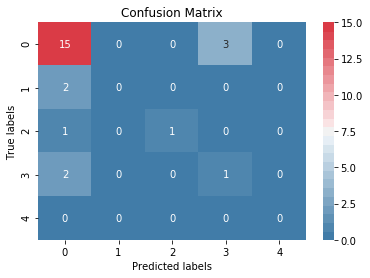

In [24]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap=sns.diverging_palette(240, 10, n=25)); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(IMPACT_CLASSES_INT); ax.yaxis.set_ticklabels(IMPACT_CLASSES_INT);

# Evaluate model


Now we simply evaluate the model, on the testing set

In [25]:
model.evaluate(testing_batch, verbose = 2)

25/25 - 3s - loss: 0.4380 - accuracy: 0.8400


[0.43798762989696116, 0.84]